# Prompt Based Harmful Message detection using MCP and LLM

## Install pre-requisites

In [1]:
!pip install datasets pandas scikit-learn matplotlib seaborn openai tqdm

In [2]:
!pip install --upgrade datasets

In [3]:
import os
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from openai import OpenAI
from dotenv import load_dotenv
import requests
tqdm.pandas()

# Load environment variables from .env file
load_dotenv()

# Configure DeepSeek API
client = OpenAI(
    api_key=os.getenv("DEEPSEEK_API_KEY"),  # Use env var or replace manually
    base_url="http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1"  # my local deepseek or deepseek API https://api.deepseek.com
)

MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"  # Replace with "deepseek-chat" or "deepseek-v3-0324" if supported


In [ ]:
# Load dataset from Hugging Face
# try:
#     # Load the dataset
#     # dataset = load_dataset("setfit/toxic_conversations", streaming=True)
#     dataset = load_dataset("setfit/toxic_conversations")
    
#     # Convert to pandas DataFrame
#     df = pd.DataFrame(dataset['train'])
    
# except ValueError as e:
#     print(f"Error loading dataset: {e}")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")

# # Display sample
# print(df.head())

# print("\nToxic conversation dataset explored successfully!")

# Save data on disk
# dataset["train"].to_csv("train.csv", index=False)
# dataset["test"].to_csv("test.csv", index=False)

In [ ]:
# # Check data imbalance
# label_size = df.groupby('label').size()
# print(label_size)

# plt.pie(label_size, explode=[0.1,0.1], colors=['firebrick','blue'], startangle=90,labels=['Non-Toxic', 'Toxic'], shadow=True, autopct='%1.1f%%')
# plt.title('Data Imbalance')
# plt.show()

In [ ]:
# # Step 2: Explore train dataset
# df_train = pd.DataFrame(dataset["train"])
# df_test = pd.DataFrame(dataset["test"])

# print("\n🔍 Class Distribution (Train):\n", df_train["label"].value_counts())
# df_train["label"].value_counts().plot(kind='bar', title='Train Set Class Distribution')
# plt.xlabel("Label (0 = Not Toxic, 1 = Toxic)")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()



In [ ]:
# # Step 2: Explore test dataset

# print("\n🔍 Class Distribution (Test):\n", df_test["label"].value_counts())
# df_test["label"].value_counts().plot(kind='bar', title='Test Set Class Distribution')
# plt.xlabel("Label (0 = Not Toxic, 1 = Toxic)")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()



In [4]:
import requests
import json
import re

def predict_with_deepseek(text):
    prompt = f"""You are a content moderation system. 
    Analyze the following message and respond ONLY with a JSON object containing: 

    "action": "allow|warn|block|timeout",
    "confidence": 0.0 - 1.0,
    "categories": ["list of violation types"]

    DO NOT include any explanation or thinking process. Return ONLY the JSON object.

Message: "{text}"
"""

    try:
        response = requests.post(
            "http://k8s-deepseek-deepseek-e92cca8149-b20547a64509f06f.elb.eu-west-1.amazonaws.com/v1/chat/completions",
            headers={"Content-Type": "application/json"},
            json={
                "model": "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
                "messages": [
                    {"role": "system", "content": "You are a content moderation assistant. Respond only with JSON."},
                    {"role": "user", "content": prompt}
                ],
                "temperature": 0
            },
            timeout=20
        )

        response.raise_for_status()
        result = response.json()
        reply = result["choices"][0]["message"]["content"].strip()

        # Extract JSON part from the response using regex
        json_match = re.search(r'\{.*\}', reply, re.DOTALL)
        
        if json_match:
            json_str = json_match.group()
            try:
                moderation_result = json.loads(json_str)
                
                # Convert action to uppercase for consistent comparison
                action = moderation_result.get("action", "").upper()
                
                # Debug output
                print(f"Extracted JSON: {json.dumps(moderation_result, indent=2)}")
                
                # Return 1 for BLOCK action, 0 for all others
                return 1 if action == "BLOCK" else 0

            except json.JSONDecodeError as je:
                print(f"⚠️ Failed to parse extracted JSON: '{json_str}'")
                print(f"JSON Error: {je}")
                return 0
        else:
            print(f"⚠️ No JSON found in response: '{reply}'")
            return 0

    except requests.exceptions.RequestException as e:
        print(f"❌ Network error: {e}")
        return 0
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return 0

## Test the function

In [5]:
# Test the function
test_text = "You are a terrible person!"
result = predict_with_deepseek(test_text)
print(f"Moderation result (1=toxic, 0=non-toxic): {result}")


Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "personal attack",
    "hate speech"
  ]
}
Moderation result (1=toxic, 0=non-toxic): 1


In [6]:
# ✅ Load your test dataset (already downloaded in previous steps)
df_test = pd.read_csv("test.csv")

# ✅ Step 4: Sample a balanced dataset (e.g., 20 toxic and 20 non-toxic)
n_samples = 20
df_toxic = df_test[df_test["label"] == 1].sample(n=n_samples, random_state=42)
df_nontoxic = df_test[df_test["label"] == 0].sample(n=n_samples, random_state=42)
sample_df = pd.concat([df_toxic, df_nontoxic]).sample(frac=1, random_state=42).reset_index(drop=True)


🔍 Sampled Dataset Class Distribution:
label
1    20
0    20
Name: count, dtype: int64


/tmp/ipykernel_9033/26813935.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sample_df, x="label", palette="coolwarm")


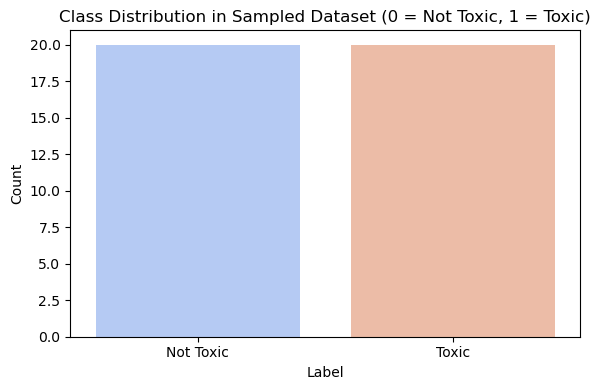

✅ Dataset is balanced.


In [7]:
# Check Class Balance After Sampling
import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution
print("🔍 Sampled Dataset Class Distribution:")
print(sample_df["label"].value_counts())

# Plot it
plt.figure(figsize=(6, 4))
sns.countplot(data=sample_df, x="label", palette="coolwarm")
plt.title("Class Distribution in Sampled Dataset (0 = Not Toxic, 1 = Toxic)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0, 1], ["Not Toxic", "Toxic"])
plt.tight_layout()
plt.show()
assert sample_df["label"].value_counts()[0] == sample_df["label"].value_counts()[1], "❌ Dataset is not balanced!"
print("✅ Dataset is balanced.")

## Model Evaluation

In [8]:
# Initialize progress bar for pandas
tqdm.pandas()

# Step 5: Get predictions
print("\n🚀 Performing inference on balanced sample data...")
sample_df["prediction"] = sample_df["text"].progress_apply(predict_with_deepseek)

# Step 6: Evaluate predictions
y_true = sample_df["label"]
y_pred = sample_df["prediction"]

metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_pred)
}

print("\n📊 Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")




🚀 Performing inference on balanced sample data...


  5%|▌         | 2/40 [00:09<02:51,  4.50s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "_sensitive_topic",
    "hate_speech",
    "incitement"
  ]
}


  8%|▊         | 3/40 [00:15<03:22,  5.46s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate_speech",
    "defamation"
  ]
}


 10%|█         | 4/40 [00:27<04:34,  7.64s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "hate speech",
    "incivility"
  ]
}


 12%|█▎        | 5/40 [00:37<04:55,  8.45s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.6,
  "categories": [
    "Content Quality"
  ]
}


 15%|█▌        | 6/40 [00:43<04:25,  7.81s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate_speech",
    "anti-Semitic",
    "offensive_language"
  ]
}


 18%|█▊        | 7/40 [00:54<04:47,  8.71s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "hate speech",
    "offensive language"
  ]
}


 20%|██        | 8/40 [01:09<05:41, 10.68s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 1.0,
  "categories": [
    "hate speech",
    "inappropriate historical comparisons"
  ]
}


 22%|██▎       | 9/40 [01:17<05:09,  9.98s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.8,
  "categories": [
    "Government Criticism"
  ]
}


 25%|██▌       | 10/40 [01:27<04:57,  9.92s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.9,
  "categories": [
    "free_speech",
    "philosophy"
  ]
}


 28%|██▊       | 11/40 [01:39<05:05, 10.53s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "abusive or harassing language",
    "hate speech"
  ]
}


 30%|███       | 12/40 [01:52<05:21, 11.49s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "Discrimination/Hate Speech"
  ]
}


 32%|███▎      | 13/40 [02:04<05:06, 11.35s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "hate_speech",
    "divisive_behavior"
  ]
}


 35%|███▌      | 14/40 [02:11<04:25, 10.21s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.9,
  "categories": []
}


 38%|███▊      | 15/40 [02:22<04:18, 10.34s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "political_opinions",
    "social_issues"
  ]
}


 40%|████      | 16/40 [02:33<04:15, 10.65s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.95,
  "categories": [
    "misuse of categories",
    "incorrect labeling"
  ]
}


 42%|████▎     | 17/40 [02:38<03:23,  8.85s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "hate_speech",
    "harassment"
  ]
}


 45%|████▌     | 18/40 [02:46<03:09,  8.61s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate speech",
    "harassment"
  ]
}


 48%|████▊     | 19/40 [02:54<03:00,  8.60s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "respectful_communication"
  ]
}


 50%|█████     | 20/40 [03:01<02:37,  7.88s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate_speech",
    "disrespectful_language",
    "public_figure"
  ]
}


 52%|█████▎    | 21/40 [03:11<02:45,  8.69s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.95,
  "categories": [
    "economic_policy_discussion",
    "sensitive_topic"
  ]
}


 55%|█████▌    | 22/40 [03:22<02:47,  9.30s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.8,
  "categories": [
    "Political Expression"
  ]
}


 57%|█████▊    | 23/40 [03:32<02:41,  9.50s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "hate_speech",
    "religious_discrimination"
  ]
}


 60%|██████    | 24/40 [03:41<02:30,  9.41s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.85,
  "categories": [
    "harassment"
  ]
}


 62%|██████▎   | 25/40 [03:51<02:23,  9.53s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "hate_speech",
    "offensive_language"
  ]
}


 65%|██████▌   | 26/40 [03:59<02:07,  9.10s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 1.0,
  "categories": []
}


 68%|██████▊   | 27/40 [04:10<02:06,  9.76s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.3,
  "categories": [
    "abusive"
  ]
}


 70%|███████   | 28/40 [04:17<01:46,  8.88s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.9,
  "categories": []
}


 72%|███████▎  | 29/40 [04:31<01:54, 10.45s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "discrimination",
    "diversity"
  ]
}


 75%|███████▌  | 30/40 [04:46<01:58, 11.89s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate_speech",
    "offensive_language"
  ]
}


 78%|███████▊  | 31/40 [04:57<01:42, 11.34s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "ad_hominem"
  ]
}


 80%|████████  | 32/40 [05:04<01:22, 10.25s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "personal_attack"
  ]
}


 82%|████████▎ | 33/40 [05:15<01:13, 10.50s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.6,
  "categories": [
    "Media Bias",
    "Political Content"
  ]
}


 85%|████████▌ | 34/40 [05:28<01:07, 11.20s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.6,
  "categories": [
    "offensive_language",
    "hate_speech"
  ]
}


 88%|████████▊ | 35/40 [05:39<00:55, 11.05s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.8,
  "categories": []
}


 90%|█████████ | 36/40 [05:43<00:36,  9.02s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate speech",
    "discrimination",
    "offensive language"
  ]
}


 92%|█████████▎| 37/40 [05:53<00:28,  9.33s/it]

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "Political Content",
    "Confrontational/Rude Behavior"
  ]
}


 95%|█████████▌| 38/40 [06:04<00:19,  9.75s/it]

Extracted JSON: {
  "action": "allow",
  "confidence": 0.8,
  "categories": [
    "opinion"
  ]
}


 98%|█████████▊| 39/40 [06:15<00:10, 10.22s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.8,
  "categories": [
    "Discrimination/Hate Speech"
  ]
}


100%|██████████| 40/40 [06:24<00:00,  9.81s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.8,
  "categories": [
    "hate_speech",
    "personal_attack"
  ]
}


100%|██████████| 40/40 [06:43<00:00, 10.08s/it]

Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate_speech",
    "harassment",
    "inappropriate_content"
  ]
}

📊 Evaluation Metrics:
Accuracy: 0.7000
Precision: 0.7500
Recall: 0.6000
F1 Score: 0.6667
AUC: 0.7000


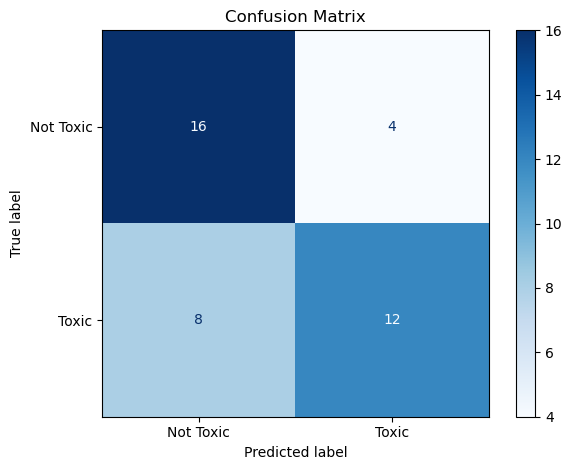

/tmp/ipykernel_9033/916961170.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")


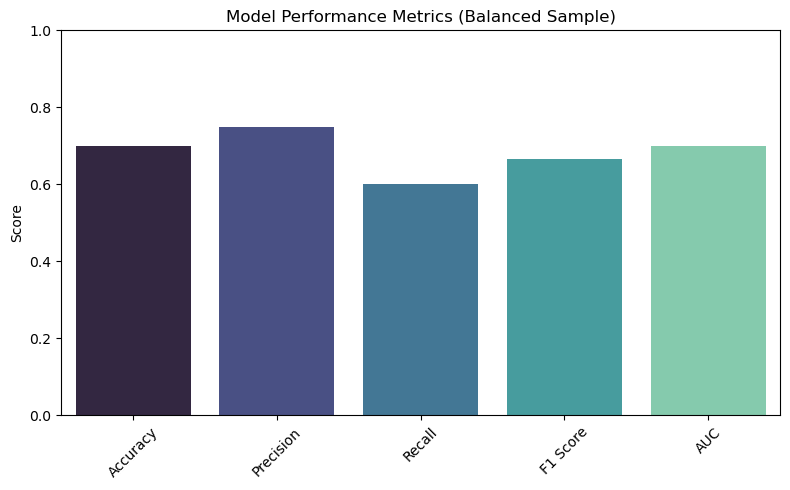

In [9]:
# ✅ Step 7: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Toxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ✅ Step 8: Bar Plot of Metrics
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="mako")
plt.title("Model Performance Metrics (Balanced Sample)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "_sensitive_topic",
    "hate_speech",
    "incitement"
  ]
}
Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate_speech",
    "defamation"
  ]
}
Extracted JSON: {
  "action": "block",
  "confidence": 0.9,
  "categories": [
    "hate_speech",
    "incivility"
  ]
}
Extracted JSON: {
  "action": "warn",
  "confidence": 0.6,
  "categories": [
    "Content Quality"
  ]
}
Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "hate_speech"
  ]
}
Extracted JSON: {
  "action": "block",
  "confidence": 1.0,
  "categories": [
    "hate_speech"
  ]
}
Extracted JSON: {
  "action": "block",
  "confidence": 0.95,
  "categories": [
    "hate_speech",
    "offensive_content"
  ]
}
Extracted JSON: {
  "action": "warn",
  "confidence": 0.7,
  "categories": [
    "Government Spending",
    "Public Policy",
    "Controversial Opinions"
  ]
}
Extracted JSON: {
  

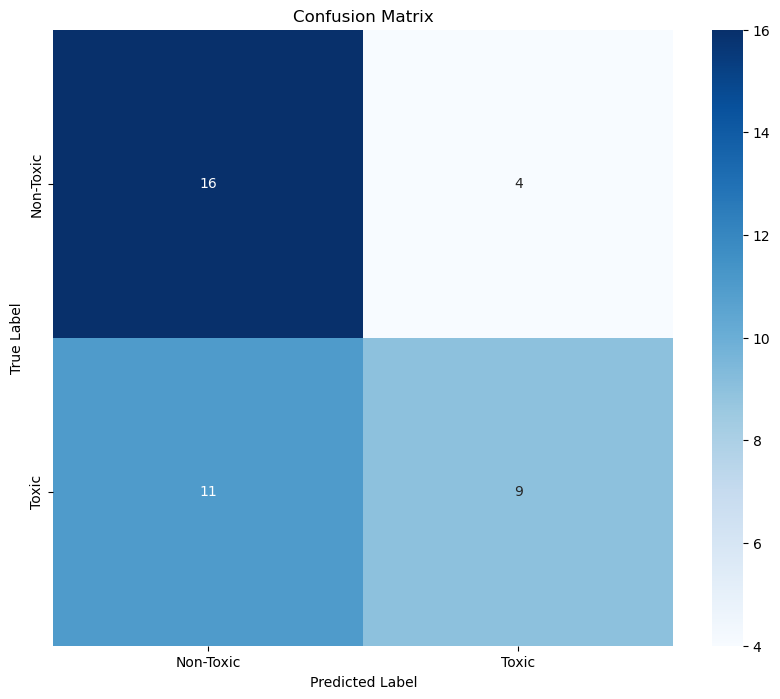

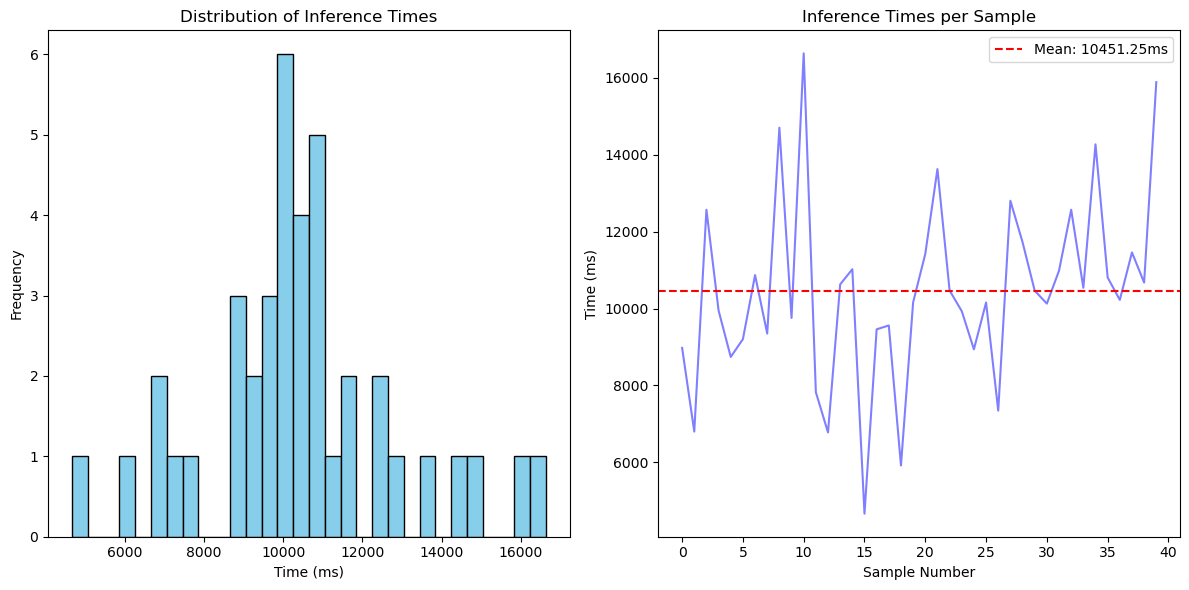


⏱️ Timing Statistics (in milliseconds):
Mean inference time: 10451.25ms
Median inference time: 10345.76ms
Std dev: 2451.91ms
Min time: 4664.11ms
Max time: 16639.64ms


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
from datetime import datetime

def generate_performance_report(y_true, y_pred, inference_times=None):
    """
    Generate classification report and visualizations
    """
    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # Create confusion matrix plot
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Toxic', 'Toxic'],
                yticklabels=['Non-Toxic', 'Toxic'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # If inference times are provided, plot them
    if inference_times is not None:
        plt.figure(figsize=(12, 6))
        
        # Convert to milliseconds for better readability
        times_ms = np.array(inference_times) * 1000
        
        # Plot histogram of inference times
        plt.subplot(1, 2, 1)
        plt.hist(times_ms, bins=30, color='skyblue', edgecolor='black')
        plt.title('Distribution of Inference Times')
        plt.xlabel('Time (ms)')
        plt.ylabel('Frequency')
        
        # Plot inference times over samples
        plt.subplot(1, 2, 2)
        plt.plot(range(len(times_ms)), times_ms, 'b-', alpha=0.5)
        plt.axhline(y=np.mean(times_ms), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(times_ms):.2f}ms')
        plt.title('Inference Times per Sample')
        plt.xlabel('Sample Number')
        plt.ylabel('Time (ms)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print timing statistics
        print("\n⏱️ Timing Statistics (in milliseconds):")
        print(f"Mean inference time: {np.mean(times_ms):.2f}ms")
        print(f"Median inference time: {np.median(times_ms):.2f}ms")
        print(f"Std dev: {np.std(times_ms):.2f}ms")
        print(f"Min time: {np.min(times_ms):.2f}ms")
        print(f"Max time: {np.max(times_ms):.2f}ms")

# Usage example:
def measure_inference_times(texts, predict_fn):
    """
    Measure inference times for each prediction
    """
    times = []
    predictions = []
    
    for text in texts:
        start_time = time.time()
        pred = predict_fn(text)
        end_time = time.time()
        
        times.append(end_time - start_time)
        predictions.append(pred)
    
    return predictions, times

# Run predictions with timing
predictions, inference_times = measure_inference_times(sample_df["text"], predict_with_deepseek)

# Generate report
generate_performance_report(
    y_true=sample_df["label"],
    y_pred=predictions,
    inference_times=inference_times
)

# Optional: Save results to CSV
results_df = pd.DataFrame({
    'text': sample_df["text"],
    'true_label': sample_df["label"],
    'predicted_label': predictions,
    'inference_time_ms': np.array(inference_times) * 1000
})

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_df.to_csv(f'moderation_results_{timestamp}.csv', index=False)